# Lab 11: Self-Organizing Maps 

Learning Objectives:

- Understand SOM Fundamentals
- Train and Evaluate SOMs
- Analyze SOM Visualizations
- Implement Two-Stage Clustering

## Imports and Data Loading

In [277]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import RegularPolygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import cm, colorbar
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors as mpl_colors
from matplotlib.colors import Normalize

# Clustering algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering

# Self-Organizing Maps
from minisom import MiniSom

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Visualization styling
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

# Set random seed for reproducibility
np.random.seed(42)

In [278]:
# Helper functions from Labs 09-12 for R² calculation

def get_ss(df, features):

    return np.sum(df[features].var() * (df[features].count() - 1))


def get_ssw(df, features, label_col):

    return df.groupby(label_col)[features].apply(
        lambda x: get_ss(x, features)
    ).sum()


def get_ssb(df, features, label_col):

    sst = get_ss(df, features)
    ssw = get_ssw(df, features, label_col)
    return sst - ssw


def get_rsq(df, features, label_col):

    sst = get_ss(df, features)
    ssw = get_ssw(df, features, label_col)
    return 1 - (ssw / sst)



In [279]:
# Load preprocessed customer data
df = pd.read_csv('../data/data_preprocessed.csv')

df.head()

,age,income,frq,rcn,mnt,clothes,kitchen,small_appliances,toys,house_keeping,...,oh_status_Widow,oh_gender_M,oh_dependents_1.0,oh_description_Kind of OK,oh_description_Meh...,oh_description_OK nice!,oh_description_Take my money!!,PC0,PC1,PC2
0,78,0.743162,1.191605,0.457819,1402,-0.617023,-0.243065,1.216847,0.495837,-0.499274,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.896356,-1.937697,1.120781
1,88,1.559488,1.100011,-1.535723,1537,0.166160,-0.790228,0.740464,-0.374374,-0.631907,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.981092,-1.421498,0.785625
2,34,-1.548542,-0.823463,0.557496,44,-0.834573,1.672006,-0.371096,-0.809480,2.286023,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,-2.813108,0.381440,-0.780867
3,69,0.845528,0.550447,-1.402820,888,0.383710,0.440889,-0.768082,-0.084304,-0.234007,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.247013,-0.514177,-1.302203
4,69,0.782435,1.008417,-0.871209,1138,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.781920,-0.704805,-0.443376


In [280]:
# Metric features for SOM training and clustering (10 total)
metric_features = [
    'income',           # Annual income
    'frq',              # Purchase frequency
    'rcn',              # Recency (days since last purchase)
    'clothes',          # Spending on clothing
    'kitchen',          # Kitchen items spending
    'small_appliances', # Small appliances spending
    'toys',             # Toy purchases
    'house_keeping',    # Housekeeping products spending
    'per_net_purchase', # Average purchase value
    'spent_online'      # Online channel spending
]

# Categorical variables (for profiling, not clustering)
categorical_features = ['education', 'status', 'gender']

# Self-organizing maps: Fundamentals

What is a SOM? How does it work? What is it used for?

The SOM objective is to adjust the units to the data in the input space, so that the
network is (as best as possible) representative of the training dataset.

### How is it computed?



Observations: 

<div align="center"> 

| Data Point | Income | Age | Toys | Kitchen |
|:----------:|:-----------------:|:-----------------:|:-----------------:|:-----------------:|
| $\mathbf{x}_1$ | 0.9 | 0.1 | 0.1 | 0.9 |
| $\mathbf{x}_2$ | 0.8 | 0.2 | 0.2 | 0.8 |
| $\mathbf{x}_3$ | 0.1 | 0.9 | 0.9 | 0.1 |
| $\mathbf{x}_4$ | 0.2 | 0.8 | 0.8 | 0.2 |

 </div>

<br>

Units: 
<div align="center"> 

| Neuron | $w_1$ | $w_2$ | $w_3$ | $w_4$ |
|:------:|:-----:|:-----:|:-----:|:-----:|
| $\mathbf{w}_1$ | 0.70 | 0.30 | 0.30 | 0.70 |
| $\mathbf{w}_2$ | 0.30 | 0.70 | 0.70 | 0.30 |

</div>

Concepts: 
- Best Matching Unit (BMU): closest weight vector 
- Update of weights based of BMU and neighborhood (neighborhood function)
   - Unfolding phase: Large neighborhood radius, spread units across input space
   - Fine-tuning phase: Small neighborhood radius, reduce quantization error

Characteristics: 
- Visualization high-D data in a 2D grid: similarity relationships preserved 
- Capable of finding the global optimum (theoretically if LR -> 0)
- Grid shape need to be set a priori 
- Results depend on the initializaiton 
- Fitting a SOM can be computationally expensive 

**Video**

https://www.youtube.com/watch?v=k7DK5fnJH94

### Important concepts

- Units and observations
- BMU
- Neighborhood function
- Input and Output space

![SOM Input Output Space](./../figures/clustering/SOM_InputOutputSpace.png)

### Helper functions for SOM viz

In [281]:
## SOM Visualization Helpers

def get_index_matrix(nx, ny):
    # Given nx=2, ny=3
    # This will return a matrix whose contents are the index values:
    # 
    # (0,0) (0,1) (0,2)
    # (1,0) (1,1) (1,2)

    x = np.linspace(0, nx-1, nx)
    y = np.linspace(0, ny-1, ny)
    xv, yv = np.meshgrid(x, y, indexing='xy')


    mx_index = np.full((nx,ny),str)

    for i, j in zip(xv,yv):    
        for ii, jj  in zip(i,j):
            ii = int(ii)
            jj = int(jj)
            mx_index[ii,jj] = f"({ii},{jj})"

    return mx_index



# Visualize RGB SOM as colored grid

def plot_rgb_matrix(som_matrix, som, ax, annot_mx=None):

    som_x, som_y = som.get_weights().shape[:2]
    
    for i in range(som_x):
        for j in range(som_y):
            # Get RGB color for this unit (ensure values in 0-1 range)
            color = np.clip(som_matrix[i, j], 0, 1)
            
            # Convert grid to hexagonal coordinates
            hex_coord = som.convert_map_to_euclidean((i, j))
            
            center = [hex_coord[0], hex_coord[1]]
            
            # Draw hexagon with learned color
            hexagon = RegularPolygon(
                center, 
                numVertices=6, 
                radius=np.sqrt(1/3),
                facecolor=color, 
                edgecolor='white', 
                linewidth=2
            )
            ax.add_patch(hexagon)
            
            if "None" in str((type(annot_mx))):
                pass 
            else:
                
                annot_val = annot_mx[i,j]
                if "str" in str(type(annot_val)):
                    pass 
                else:
                    if int(annot_val) == annot_val:
                        annot_val = int(annot_val)
                
                ax.text(center[0], center[1], annot_val, 
                        ha='center', va='center',
                        fontsize='x-small')
    

    
    ax.set_xlim(-1, som_x-.5)
    ax.set_ylim(-1, som_y)
    ax.set_aspect('equal')
    ax.axis('off')

    return ax


## Clustering different colors with SOM 

- 1000 colors 
- 3 features (R,G,B) each 

*What is RGB?*

https://www.w3schools.com/colors/colors_rgb.asp

In [282]:
# Create RGB color dataset (random samples from color space)
n_colors = 1000

# Initialize Random Number Generator with seed from numpy
rng = np.random.default_rng(638468314)

rgb_data = rng.integers(0, 256, size=(n_colors, 3))
rgb_df = pd.DataFrame(rgb_data, columns=['R', 'G', 'B'])



In [283]:
rgb_df.head()

,R,G,B
0,52,157,227
1,70,234,67
2,118,243,49
3,71,52,132
4,81,196,88


In [284]:
# Normalize to 0-1 range for SOM
rgb_normalized = rgb_data / 255.0
rgb_normalized

array([[0.20392157, 0.61568627, 0.89019608],
       [0.2745098 , 0.91764706, 0.2627451 ],
       [0.4627451 , 0.95294118, 0.19215686],
       ...,
       [0.46666667, 0.74901961, 0.05490196],
       [0.30980392, 0.45882353, 0.84313725],
       [0.32941176, 0.88235294, 0.8       ]])

In [285]:
rgb_x = 6
rgb_y = 5

som_rgb = MiniSom(x=rgb_x, y=rgb_y,             # Size of SOM grid  
                  input_len=3,                  # Number of features (RGB)
                  sigma=1.5,                    # Neighborhood radius
                  learning_rate=0.5,            # Learning rate 
                  neighborhood_function='gaussian',  # Neighborhood function
                  topology='hexagonal',          # N_neighborhood topology
                  random_seed=42
                  )

In [286]:
# Initialize grid weights

som_rgb.random_weights_init(rgb_normalized)

# Extract learned color weights and display as grid
weights_rgb_init = som_rgb.get_weights()



#### How many total units we have ? 

In [287]:
print(weights_rgb_init.shape)
print(weights_rgb_init[0, 0])
print(weights_rgb_init[0, 1])

(6, 5, 3)
[0.20784314 0.85882353 0.02745098]
[0.94509804 0.27843137 0.56078431]


In [288]:
# Get the index annotations
rgb_annot = get_index_matrix(rgb_x, rgb_y)

print(rgb_annot)

[['(0,0)' '(0,1)' '(0,2)' '(0,3)' '(0,4)']
 ['(1,0)' '(1,1)' '(1,2)' '(1,3)' '(1,4)']
 ['(2,0)' '(2,1)' '(2,2)' '(2,3)' '(2,4)']
 ['(3,0)' '(3,1)' '(3,2)' '(3,3)' '(3,4)']
 ['(4,0)' '(4,1)' '(4,2)' '(4,3)' '(4,4)']
 ['(5,0)' '(5,1)' '(5,2)' '(5,3)' '(5,4)']]


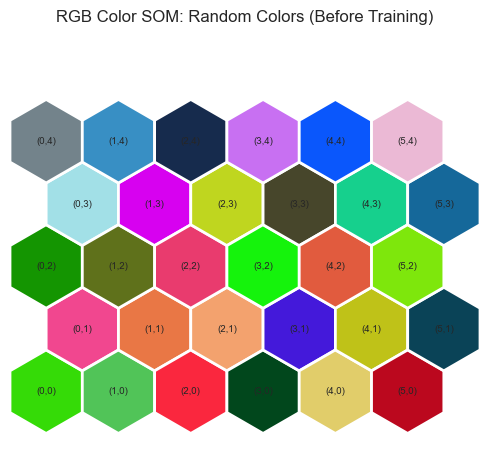

In [289]:
fig, ax = plt.subplots(figsize=(5, 5), tight_layout=True)

ax = plot_rgb_matrix(weights_rgb_init, som_rgb, ax, rgb_annot)

ax.set_title('RGB Color SOM: Random Colors (Before Training)')

plt.show()

In [290]:
# Train SOM network

som_rgb.train_batch(
    rgb_normalized, 
    num_iteration=1000, 
    verbose=False
    )

In [291]:
weights_rgb_trained = som_rgb.get_weights()
weights_rgb_trained.shape

(6, 5, 3)

In [292]:
print(weights_rgb_trained[0,0])
print(weights_rgb_trained[0, 1])


[0.82108713 0.78934338 0.34284407]
[0.73067996 0.7809894  0.5171733 ]


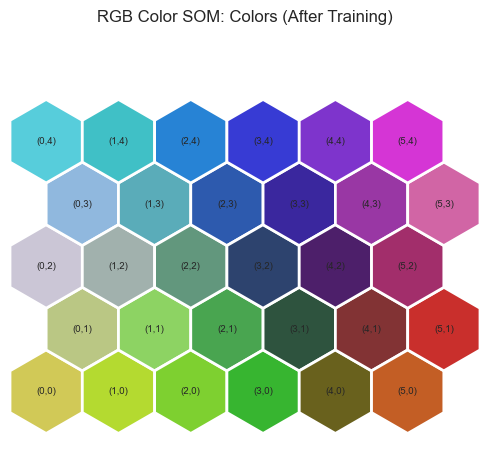

In [293]:
fig, ax = plt.subplots(figsize=(5, 5), tight_layout=True)

ax = plot_rgb_matrix(weights_rgb_trained, som_rgb, ax, rgb_annot)

ax.set_title('RGB Color SOM: Colors (After Training)')

plt.show()

.

.

.

Another [example](https://claude.ai/public/artifacts/7adace5e-7abd-4572-91e7-00ac26fc166c) of clustering an image using SOMs 
- Clustering an image of 20x12 pixels (20, 10, 3) 
- Using a 6x5 grid 



## Applying SOM to our data

In [294]:
# Prepare customer data for SOM training
som_data = df[metric_features].values

In [295]:
sm = MiniSom(
    x=10,            # Grid width 
    y=10,            # Grid height   
    input_len=len(metric_features),
    sigma=2.0,                           # Neighborhood radius
    learning_rate=0.5,                   # Learning rate
    neighborhood_function='gaussian',     # Gaussian weighting
    topology='hexagonal',
    random_seed=42                        # For reproducibility
)

Also see documentation on [github](https://github.com/JustGlowing/minisom) for more hyperparameters.

.

.

.


A note on the MiniSOM implementation:

```
.train()

num_iteration : int
    If use_epochs is False, the weights will be
    updated num_iteration times. Otherwise they will be updated
    len(data)*num_iteration times.

use_epochs : bool (default=False)
    If True the SOM will be trained for num_iteration epochs.
    In one epoch the weights are updated len(data) times and
    the learning rate is constat throughout a single epoch.
```

Using `.train_batch()` is equivalent to using `.train(data, num_iteration, use_epochs=False, random_order=False)`


This means that if you have 100 data points, and <br>
Use `.train_batch(num_iteration=50)`:

- the weights will be updated 50 times
- the data points will be presented to the network in sequence
- only the first 50 data points will be presented 


Using `.train(num_iterations=50, use_epochs=True)` instead, for the same values:

- in one epoch, all the data points will be presented to the network
- the network will be trained for 50 epochs
- the data points will be presented to the network in sequence
- each of the 100 data points will be presented 50 times
- the weights will be updated 100*50 times


# Understanding SOM Quality Metrics

**Quantization Error (QE):** 
- average distance between each data point and its BMU

$$q_e = \frac{\sum_{i=0}^{N_e}||x_i - w_e||}{N_e}$$

$$Q = \frac{\sum_{e=0}^Eq_e}{E}$$

- where:
    - $Q$ is the overall quantization error of SOM,
    - $q_e$ is the quantization error for unit $e$,
    - $x_i$ is a data point/ observation,
    - $w_e$ is the unit $e$ representation in the input space,
    - $N_e$ is number of data points mapped to unit $e$,
    - $E$ is the number of units in the SOM grid
- Data representation measure

<br>
<br>

**Topographic Error (TE):**
- proportion of data points for which first and second BMUs are not adjacent 
    - range [0,1]
- Topology preservation measure 

In [296]:
sm.random_weights_init(som_data)

qe_before = sm.quantization_error(som_data)
te_before = sm.topographic_error(som_data)

print(f"Quantization Error (QE): {qe_before:.4f}")
print(f"Topographic Error (TE):  {te_before:.4f}")

Quantization Error (QE): 1.5345
Topographic Error (TE):  0.9543


In [297]:
sm.train_batch(
    som_data, 
    num_iteration=20_000, 
    verbose=False
    )

In [298]:
qe_after = sm.quantization_error(som_data)
te_after = sm.topographic_error(som_data)

print(f"Quantization Error (QE): {qe_after:.4f}")
print(f"Topographic Error (TE):  {te_after:.4f}")

print(f"QE reduction: {qe_before:.4f} → {qe_after:.4f} ({(1 - qe_after/qe_before)*100:.1f}% improvement)")
print(f"TE reduction: {te_before:.4f} → {te_after:.4f} ({(1 - te_after/te_before)*100:.1f}% improvement)")

Quantization Error (QE): 1.4266
Topographic Error (TE):  0.1198
QE reduction: 1.5345 → 1.4266 (7.0% improvement)
TE reduction: 0.9543 → 0.1198 (87.4% improvement)


In [299]:
weights = sm.get_weights()

In [300]:
som_annot = get_index_matrix(10,10)


#### How many units the grid has?

#### Whats the the dimensionality of each unit?

#### What is the shape of the weights array?

In [301]:
weights.shape

(10, 10, 10)

In [302]:
print(weights[0, 0])
print(weights[0, 1])

[ 1.05624895  1.51033612 -0.35708444  0.83986904 -0.35433554 -0.86355851
 -0.50800798 -0.3251147   0.2951024   3.02255184]
[ 1.27241983  1.42220122 -0.0991262   0.26308119 -0.02168488 -0.24852774
 -0.24357633 -0.16755647 -0.02661984  2.48776202]


#### What do these values represent? 

. 

.

.

# Visualizing data wih SOMs


## Component Planes

Feature distribution across the SOM grid

- Data distribution
- Outlier detection 
- Feature correlation 

In [303]:
print(metric_features[0])

weights[:,:,0].shape

income


(10, 10)

In [304]:

def plot_hexagons(som_matrix, som, sf, 
                  label='', cmap=None, 
                  annot_mx=None):

    som_x, som_y = som.get_weights().shape[:2]
    
    show_cbar = False if "None" in str((type(cmap))) else True
    
    # Normalize the values to [0,1] to calculate color
    colornorm = mpl_colors.Normalize(vmin=np.min(som_matrix), vmax=np.max(som_matrix))
    
    ax = sf.subplots(1,1)

    
    for i in range(som_x):
        for j in range(som_y):
            if "None" in str((type(cmap))):
                # Get RGB color for this unit (ensure values in 0-1 range)
                color = np.clip(som_matrix[i, j], 0, 1)
            else:
                color = cmap(colornorm((som_matrix[i, j])))

            # Convert grid to hexagonal coordinates
            hex_coord = som.convert_map_to_euclidean((i, j))
            
            center = [hex_coord[0], hex_coord[1]]
            
            # Draw hexagon with learned color
            hexagon = RegularPolygon(
                center, 
                numVertices=6, 
                radius=np.sqrt(1/3),
                facecolor=color, 
                edgecolor='white', 
                linewidth=2
            )
            ax.add_patch(hexagon)
            
            if "None" in str((type(annot_mx))):
                pass 
            else:
                
                annot_val = annot_mx[i,j]
                if "str" in str(type(annot_val)):
                    pass 
                else:
                    if int(annot_val) == annot_val:
                        annot_val = int(annot_val)
                
                ax.text(center[0], center[1], annot_val, 
                        ha='center', va='center',
                        fontsize='x-small')
                
            
    
    ax.set_title(label)

    
    ax.set_xlim(-1, som_x)
    ax.set_ylim(-1, som_y)
    ax.set_aspect('equal')
    ax.axis('off')

    if show_cbar:
        ### Add colorbar
        divider = make_axes_locatable(ax)
        ax_cb = divider.append_axes("right", size="5%", pad="0%")

        ## Create a Mappable object for colorbar
        cmap_sm = plt.cm.ScalarMappable(cmap=cmap, norm=colornorm)
        cmap_sm.set_array([])

        ## Create custom colorbar 
        cb1 = colorbar.Colorbar(ax_cb,
                                orientation='vertical', 
                                alpha=1,
                                mappable=cmap_sm
                                )
        cb1.ax.get_yaxis().labelpad = 6

        # Add colorbar to plot
        sf.add_axes(ax_cb)


    return ax





In [305]:
figsize=(9,6)

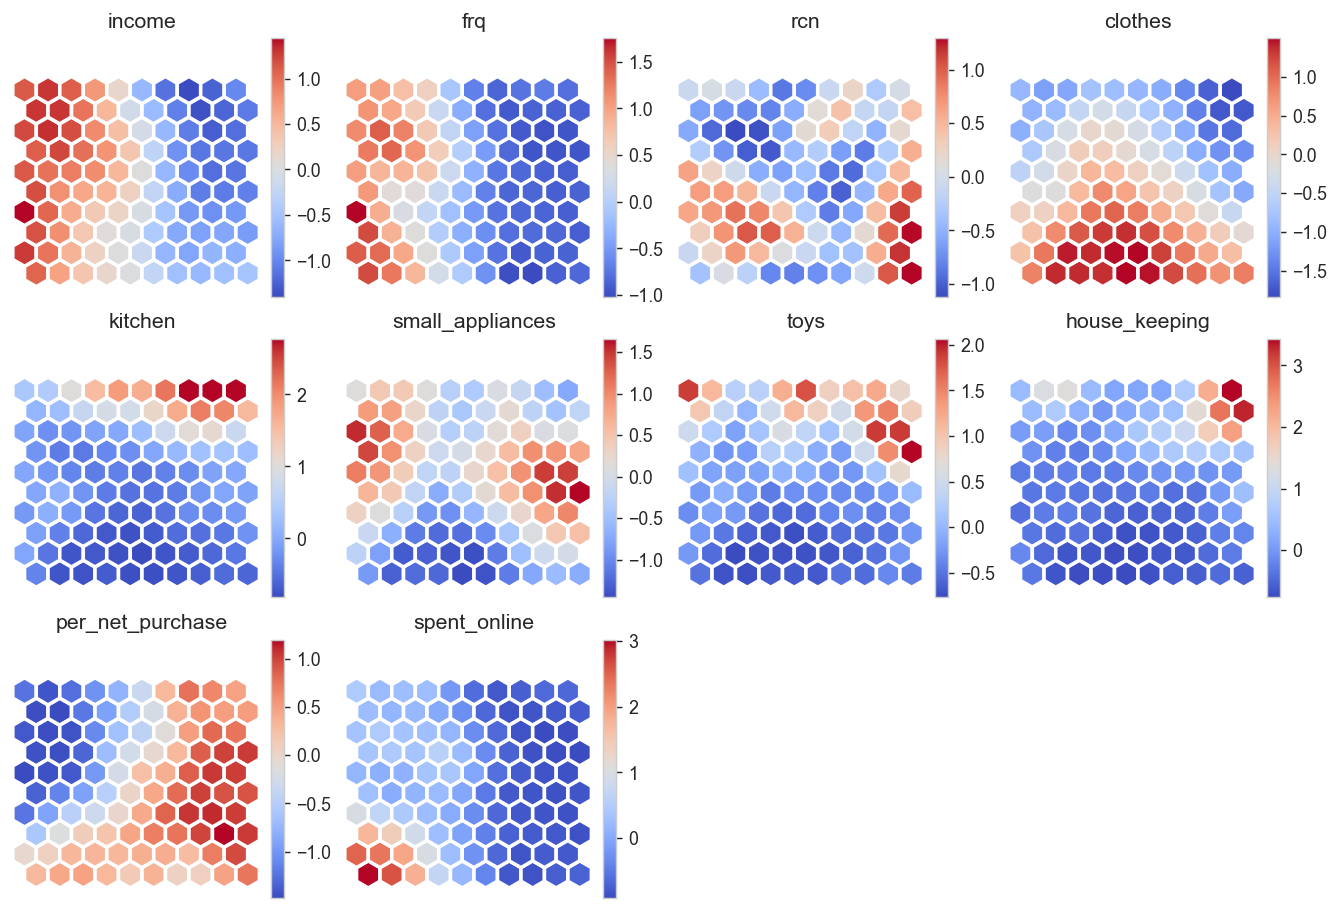

In [306]:
cmap = cm.coolwarm


fig = plt.figure(figsize=(10,7), constrained_layout=True, dpi=128, )

# Create Sub-figures
subfigs = fig.subfigures(3,4,wspace=.15)

# Plot one Component Plane for each subfigure
for cpi, sf in zip(range(len(metric_features)), subfigs.flatten()):
    
    # Get the weights of a single component
    matrix_vals = weights[:,:,cpi]


    sf = plot_hexagons(matrix_vals, 
                       sm, sf, 
                       label=metric_features[cpi],      # Add Component Plane title
                       cmap=cmap , annot_mx=None)



plt.show()


#### What features are relatively uniform ? 

#### Where can you find outliers ? 

#### Two features positively correlated ? And negatively ?

#### What customers segments might exist based on these patterns ? 

.

.

## U-Matrix (Unified Distance Matrix)

Shows average **distance** between each SOM unit and its neighbors

Analyse: 
- Clusters of units 
- Potential outliers 

In [307]:
umatrix = sm.distance_map(scaling='mean')

## Flip and rotate to match plot
print(np.flip(np.round(umatrix,2), axis=1).T)


[[0.82 0.77 0.82 0.83 0.82 0.88 0.69 0.85 0.83 0.78]
 [0.56 0.66 0.8  0.83 0.84 0.85 0.85 0.89 0.92 0.93]
 [0.54 0.63 0.7  0.72 0.77 0.81 0.86 0.89 0.93 0.87]
 [0.5  0.62 0.62 0.62 0.61 0.69 0.77 0.81 0.86 1.  ]
 [0.55 0.6  0.67 0.65 0.66 0.69 0.61 0.73 0.8  0.68]
 [0.49 0.61 0.59 0.66 0.66 0.73 0.61 0.59 0.75 0.67]
 [0.8  0.74 0.67 0.58 0.64 0.65 0.56 0.68 0.6  0.49]
 [0.66 0.83 0.84 0.67 0.52 0.52 0.56 0.62 0.64 0.46]
 [0.79 0.74 0.81 0.68 0.52 0.52 0.51 0.66 0.56 0.47]
 [0.65 0.7  0.65 0.76 0.56 0.49 0.45 0.44 0.54 0.47]]


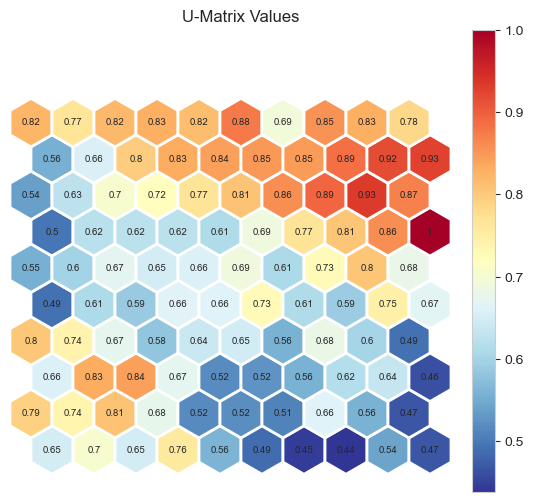

In [308]:
fig = plt.figure(figsize=(9,6))
umx_annot = get_index_matrix(10,10)

plot_hexagons(umatrix,
              sm, fig, 
              label="U-Matrix Values",      # Add Component Plane title
              cmap=cm.RdYlBu_r , 
              annot_mx=np.round(umatrix,2))

plt.show()

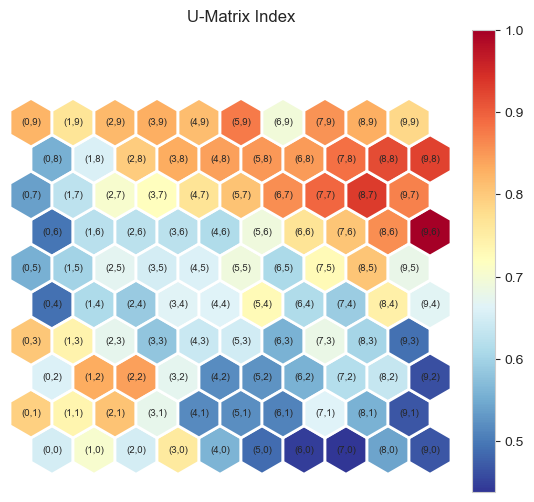

In [309]:
fig = plt.figure(figsize=(9,6))

plot_hexagons(umatrix,
              sm, fig, 
              label="U-Matrix Index",      # Add Component Plane title
              cmap=cm.RdYlBu_r , 
              annot_mx=som_annot)

plt.show()

#### How many clusters can you identify ? Characterize them 

#### Where are the potential outliers located ? Characterize them

. 

.

#### Homework 

- Improve the U-matrix visualizationg by marking high distance units
- Suggestion: threshold = u_matrix.mean() + u_matrix.std()

## Hit-map 

Show the **frequency** of each Unit in the output map



In [310]:
hitsmatrix = sm.activation_response(df[metric_features].values)

## Values of HITS:
## Flip and rotate to match plot
np.flip(np.round(hitsmatrix,2), axis=1).T


array([[121.,  89., 108., 123.,  47.,  71.,  55., 111.,  62.,  63.],
       [ 52.,  64.,  54.,  53.,  52.,  59.,  93.,  48.,  48.,  94.],
       [ 84.,  99.,  72.,  39.,  64.,  94.,  93.,  62.,  68., 126.],
       [ 96.,  88., 109.,  88.,  56.,  48.,  76., 109.,  85., 123.],
       [166.,  65.,  64., 106.,  80.,  97.,  68., 102., 100.,  91.],
       [ 84., 100.,  91.,  91.,  83.,  70.,  85.,  66.,  85., 115.],
       [181.,  74., 105.,  82.,  60.,  85., 127.,  67.,  80., 103.],
       [102., 122.,  74., 103., 115.,  75.,  74.,  76.,  62., 116.],
       [120.,  55.,  86.,  95.,  60.,  59.,  64.,  58.,  92., 120.],
       [110.,  60., 133., 173., 102., 131.,  89.,  65., 126., 181.]])

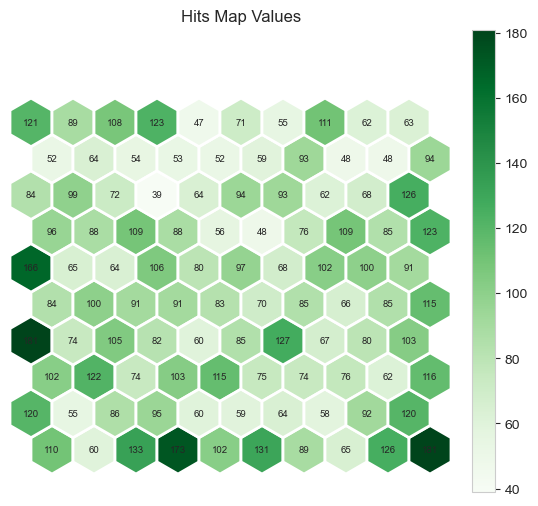

In [311]:
fig = plt.figure(figsize=(9,6))

plot_hexagons(hitsmatrix,
              sm, fig, 
              label="Hits Map Values",
              cmap=cm.Greens , 
              annot_mx=np.round(hitsmatrix,2))

plt.show()

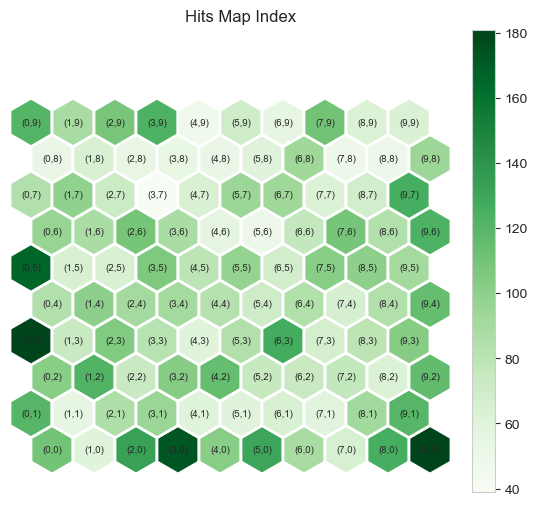

In [312]:
fig = plt.figure(figsize=(9,6))

plot_hexagons(hitsmatrix,
              sm, fig, 
              label="Hits Map Index",
              cmap=cm.Greens , 
              annot_mx=som_annot)

plt.show()

#### Are customers evenly distributed across the grid ? Any empty units ? 

#### Which grid positions have the highest customer count ? And the lowest ? 

In [313]:
print(f"Average customers per unit: {hitsmatrix.mean():.1f}")

Average customers per unit: 88.2


In [314]:
print(f"Frequency range: {hitsmatrix.min():.0f} (least) to {hitsmatrix.max():.0f} (most)")

Frequency range: 39 (least) to 181 (most)


#### Homework 

- Identify on the Hit-map customers in the lowest density units 
- Characterize them

. 

.

.

# Two-Stage Clustering with SOM

Use SOM weights as input to a traditional clustering algorithm 

Advantages:
- Computational efficiency
- Pattern preservation

#### Emergent SOM 

A very large number of units is used (eg: 50*50). This allows for very clear U-matirces and is useful for detecting quite clearly the underlying structue of the data. 

Can also be used with other clustering algorithms



In [315]:
M = 20 
N = 30  

neighborhood_function = 'gaussian' 
n_feats = len(metric_features)
learning_rate = .5
topology='hexagonal'

som_data = df[metric_features].values

sm = MiniSom(M, N,              
             n_feats,        
             learning_rate=learning_rate, 
             topology=topology, 
             neighborhood_function=neighborhood_function, 
             sigma=1.8,
             activation_distance='euclidean',
             random_seed=42
             )

#### Homework

Systematically experiment and evaluate how SOM parameters affect quality metrics (QE and TE)

Suggestions 
- Different grid sizes 5x5, 20x20, and emergent SOM with 50x50
- Different learning rates: 0.1, 0.5, 1.0
- Different sigma values: 0.5, 1.0, 2.0



In [316]:
sm.random_weights_init(som_data) 

print(np.round(sm.quantization_error(som_data),4), "Starting QE")
print(np.round(sm.topographic_error(som_data),4), "Starting TE")

1.0719 Starting QE
0.9917 Starting TE


In [317]:
sm.train_batch(som_data, 500_000)


In [318]:

print(np.round(sm.quantization_error(som_data),4),"Ending QE")
print(np.round(sm.topographic_error(som_data),4),"Ending TE")


1.0283 Ending QE
0.168 Ending TE


In [319]:
weights = sm.get_weights()

weights.shape

(20, 30, 10)

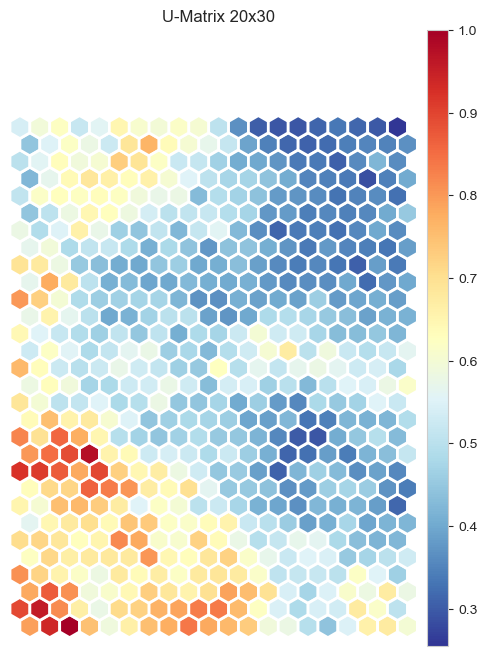

In [320]:
figsize = (6,8)

umatrix = sm.distance_map(scaling='mean')
fig = plt.figure(figsize=figsize)

plot_hexagons(umatrix,
              sm, fig, 
              label=f"U-Matrix {M}x{N}",
              cmap=cm.RdYlBu_r, 
              )

plt.show()

#### K-means on SOM units

In [321]:
weights_flat = weights.reshape(M * N, len(metric_features))

weights_flat.shape

(600, 10)

In [322]:
weights_df = pd.DataFrame(weights_flat, columns=[metric_features])

weights_df

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online
0,-1.547572,-0.914429,0.698038,-1.852346,2.639500,-0.538699,-0.170008,4.176312,1.082449,-0.889371
1,-1.442189,-0.806634,-0.597880,-1.855963,2.670143,-0.772710,0.168341,4.226040,1.099339,-0.770898
2,-1.473547,-0.786728,-1.056853,-1.735102,3.340671,-0.574023,0.170630,2.874403,1.029806,-0.761533
3,-1.034545,-0.544457,-1.093166,-1.469357,3.275865,-0.104549,-0.059763,1.553162,0.869857,-0.441881
4,-1.098169,-0.806358,-0.838437,-1.124706,2.913931,0.143714,0.231061,0.142330,0.610189,-0.710452
...,...,...,...,...,...,...,...,...,...,...
595,-0.086172,-0.626571,-0.540999,1.211641,-0.664649,-1.105025,-0.705485,-0.551583,-0.395562,-0.514124
596,-0.091143,-0.778351,0.026258,1.477883,-0.791098,-1.394752,-0.805676,-0.664752,-0.337676,-0.610469
597,-0.312720,-0.879300,0.640378,1.524655,-0.826430,-1.406083,-0.819509,-0.760150,0.130926,-0.727414
598,-0.408534,-0.898935,1.283081,1.576805,-0.798144,-1.540799,-0.781614,-0.765246,0.165264,-0.749318


#### How could you choose K for K-means ?

#### Homework

In [323]:
# For demonstration, we'll use K=4 
K = 4 

# Cluster the SOM prototypes (not customers!)
kmeans_som = KMeans(n_clusters=K, random_state=42, n_init=10, init='k-means++')

kmeans_units_labels = kmeans_som.fit_predict(weights_df[metric_features])


In [324]:
weights_df['Kmeans_units_labels'] = kmeans_units_labels
weights_df

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,Kmeans_units_labels
0,-1.547572,-0.914429,0.698038,-1.852346,2.639500,-0.538699,-0.170008,4.176312,1.082449,-0.889371,3
1,-1.442189,-0.806634,-0.597880,-1.855963,2.670143,-0.772710,0.168341,4.226040,1.099339,-0.770898,3
2,-1.473547,-0.786728,-1.056853,-1.735102,3.340671,-0.574023,0.170630,2.874403,1.029806,-0.761533,3
3,-1.034545,-0.544457,-1.093166,-1.469357,3.275865,-0.104549,-0.059763,1.553162,0.869857,-0.441881,3
4,-1.098169,-0.806358,-0.838437,-1.124706,2.913931,0.143714,0.231061,0.142330,0.610189,-0.710452,3
...,...,...,...,...,...,...,...,...,...,...,...
595,-0.086172,-0.626571,-0.540999,1.211641,-0.664649,-1.105025,-0.705485,-0.551583,-0.395562,-0.514124,1
596,-0.091143,-0.778351,0.026258,1.477883,-0.791098,-1.394752,-0.805676,-0.664752,-0.337676,-0.610469,1
597,-0.312720,-0.879300,0.640378,1.524655,-0.826430,-1.406083,-0.819509,-0.760150,0.130926,-0.727414,1
598,-0.408534,-0.898935,1.283081,1.576805,-0.798144,-1.540799,-0.781614,-0.765246,0.165264,-0.749318,1


In [325]:
weights_df['Kmeans_units_labels'].value_counts().sort_index()

(Kmeans_units_labels,)
0                         153
1                         198
2                         118
3                         131
Name: count, dtype: int64

#### HC on SOM units

##### How to define the best linkage method for HC on SOM units? And the optimal K ? 

##### Homework 

In [326]:
hc_som = AgglomerativeClustering(n_clusters=K, linkage='ward')

hc_units_labels = hc_som.fit_predict(weights_df[metric_features])


In [327]:
weights_df["HC_units_labels"] = hc_units_labels
weights_df

,income,frq,rcn,clothes,kitchen,small_appliances,toys,house_keeping,per_net_purchase,spent_online,Kmeans_units_labels,HC_units_labels
0,-1.547572,-0.914429,0.698038,-1.852346,2.639500,-0.538699,-0.170008,4.176312,1.082449,-0.889371,3,0
1,-1.442189,-0.806634,-0.597880,-1.855963,2.670143,-0.772710,0.168341,4.226040,1.099339,-0.770898,3,0
2,-1.473547,-0.786728,-1.056853,-1.735102,3.340671,-0.574023,0.170630,2.874403,1.029806,-0.761533,3,0
3,-1.034545,-0.544457,-1.093166,-1.469357,3.275865,-0.104549,-0.059763,1.553162,0.869857,-0.441881,3,0
4,-1.098169,-0.806358,-0.838437,-1.124706,2.913931,0.143714,0.231061,0.142330,0.610189,-0.710452,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...
595,-0.086172,-0.626571,-0.540999,1.211641,-0.664649,-1.105025,-0.705485,-0.551583,-0.395562,-0.514124,1,2
596,-0.091143,-0.778351,0.026258,1.477883,-0.791098,-1.394752,-0.805676,-0.664752,-0.337676,-0.610469,1,2
597,-0.312720,-0.879300,0.640378,1.524655,-0.826430,-1.406083,-0.819509,-0.760150,0.130926,-0.727414,1,2
598,-0.408534,-0.898935,1.283081,1.576805,-0.798144,-1.540799,-0.781614,-0.765246,0.165264,-0.749318,1,2


In [328]:
weights_df['HC_units_labels'].value_counts().sort_index()

(HC_units_labels,)
0                     226
1                     170
2                     114
3                      90
Name: count, dtype: int64

#### For each customer get their BMU 

In [329]:
# Find BMU for each customer
bmu_indices = []
for customer_vec in som_data:
    bmu = sm.winner(customer_vec)  # Returns (row, col) on SOM grid
    bmu_indices.append(bmu)

bmu_indices = np.array(bmu_indices)
bmu_indices

array([[ 2, 16],
       [ 6, 21],
       [10,  2],
       ...,
       [18, 11],
       [ 8, 11],
       [ 5, 29]])

In [330]:
bmu_indices.shape

(8817, 2)

In [331]:
bmu_flat_indices = [bmu[0] * N + bmu[1] for bmu in bmu_indices]
bmu_flat_indices = np.array(bmu_flat_indices)
bmu_flat_indices


array([ 76, 201, 302, ..., 551, 251, 179])

In [332]:
bmu_flat_indices.shape

(8817,)

In [333]:
print(f"Minimum BMU flat index: {bmu_flat_indices.min()}")
print(f"Maximum BMU flat index: {bmu_flat_indices.max()}")

Minimum BMU flat index: 0
Maximum BMU flat index: 599


In [334]:
df_final = pd.concat([
                df,
                pd.Series(bmu_flat_indices, name='BMU', index=df.index)
            ], axis=1
            )

df_final

,age,income,frq,rcn,mnt,clothes,kitchen,small_appliances,toys,house_keeping,...,oh_gender_M,oh_dependents_1.0,oh_description_Kind of OK,oh_description_Meh...,oh_description_OK nice!,oh_description_Take my money!!,PC0,PC1,PC2,BMU
0,78,0.743162,1.191605,0.457819,1402,-0.617023,-0.243065,1.216847,0.495837,-0.499274,...,1.0,0.0,0.0,0.0,0.0,1.0,0.896356,-1.937697,1.120781,76
1,88,1.559488,1.100011,-1.535723,1537,0.166160,-0.790228,0.740464,-0.374374,-0.631907,...,0.0,0.0,0.0,0.0,0.0,1.0,1.981092,-1.421498,0.785625,201
2,34,-1.548542,-0.823463,0.557496,44,-0.834573,1.672006,-0.371096,-0.809480,2.286023,...,1.0,1.0,1.0,0.0,0.0,0.0,-2.813108,0.381440,-0.780867,302
3,69,0.845528,0.550447,-1.402820,888,0.383710,0.440889,-0.768082,-0.084304,-0.234007,...,0.0,1.0,0.0,0.0,1.0,0.0,1.247013,-0.514177,-1.302203,174
4,69,0.782435,1.008417,-0.871209,1138,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,...,0.0,1.0,0.0,0.0,0.0,1.0,1.781920,-0.704805,-0.443376,263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8812,70,0.618993,0.458853,-1.701851,837,0.209670,0.167308,-0.132905,0.205767,-0.764540,...,1.0,1.0,1.0,0.0,0.0,0.0,1.162525,-0.372854,-0.982963,235
8813,64,0.874744,0.733635,-1.701851,896,0.731791,-0.243065,-0.609288,-0.519409,-0.366640,...,0.0,1.0,0.0,0.0,0.0,1.0,2.003026,0.083121,-1.428619,264
8814,49,-0.455617,-0.731869,-1.535723,61,0.079139,-0.106274,-0.053508,0.060732,-0.101374,...,1.0,1.0,0.0,1.0,0.0,0.0,-1.002171,1.301747,-0.423851,551
8815,38,-0.596155,0.825229,0.657173,1011,-0.442982,0.577680,0.581670,-0.809480,0.561792,...,1.0,0.0,0.0,0.0,0.0,1.0,0.130573,-0.959962,0.332242,251


#### Map customers BMU to units labels 

In [335]:
df_final['Kmeans_labels'] = df_final['BMU'].map(
    lambda x: kmeans_units_labels[x] )

df_final['HC_labels'] = df_final['BMU'].map(
    lambda x: hc_units_labels[x] )

In [336]:
df_final

,age,income,frq,rcn,mnt,clothes,kitchen,small_appliances,toys,house_keeping,...,oh_description_Kind of OK,oh_description_Meh...,oh_description_OK nice!,oh_description_Take my money!!,PC0,PC1,PC2,BMU,Kmeans_labels,HC_labels
0,78,0.743162,1.191605,0.457819,1402,-0.617023,-0.243065,1.216847,0.495837,-0.499274,...,0.0,0.0,0.0,1.0,0.896356,-1.937697,1.120781,76,0,3
1,88,1.559488,1.100011,-1.535723,1537,0.166160,-0.790228,0.740464,-0.374374,-0.631907,...,0.0,0.0,0.0,1.0,1.981092,-1.421498,0.785625,201,0,1
2,34,-1.548542,-0.823463,0.557496,44,-0.834573,1.672006,-0.371096,-0.809480,2.286023,...,1.0,0.0,0.0,0.0,-2.813108,0.381440,-0.780867,302,3,0
3,69,0.845528,0.550447,-1.402820,888,0.383710,0.440889,-0.768082,-0.084304,-0.234007,...,0.0,0.0,1.0,0.0,1.247013,-0.514177,-1.302203,174,0,1
4,69,0.782435,1.008417,-0.871209,1138,0.340200,-0.243065,-0.053508,-0.374374,-0.366640,...,0.0,0.0,0.0,1.0,1.781920,-0.704805,-0.443376,263,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8812,70,0.618993,0.458853,-1.701851,837,0.209670,0.167308,-0.132905,0.205767,-0.764540,...,1.0,0.0,0.0,0.0,1.162525,-0.372854,-0.982963,235,2,1
8813,64,0.874744,0.733635,-1.701851,896,0.731791,-0.243065,-0.609288,-0.519409,-0.366640,...,0.0,0.0,0.0,1.0,2.003026,0.083121,-1.428619,264,2,1
8814,49,-0.455617,-0.731869,-1.535723,61,0.079139,-0.106274,-0.053508,0.060732,-0.101374,...,0.0,1.0,0.0,0.0,-1.002171,1.301747,-0.423851,551,1,0
8815,38,-0.596155,0.825229,0.657173,1011,-0.442982,0.577680,0.581670,-0.809480,0.561792,...,0.0,0.0,0.0,1.0,0.130573,-0.959962,0.332242,251,0,1


In [337]:
print(df_final['Kmeans_labels'].value_counts().sort_index())

print(df_final['HC_labels'].value_counts().sort_index())

Kmeans_labels
0    2136
1    3203
2    1768
3    1710
Name: count, dtype: int64
HC_labels
0    3090
1    2522
2    1982
3    1223
Name: count, dtype: int64


In [338]:
r2_kmeans = get_rsq(df_final, metric_features, 'Kmeans_labels')
r2_hc = get_rsq(df_final, metric_features, 'HC_labels')

print(f"R² for K-means clustering on SOM units:     {r2_kmeans:.4f}")
print(f"R² for HC on SOM units:                     {r2_hc:.4f}")

R² for K-means clustering on SOM units:     0.4550
R² for HC on SOM units:                     0.4033


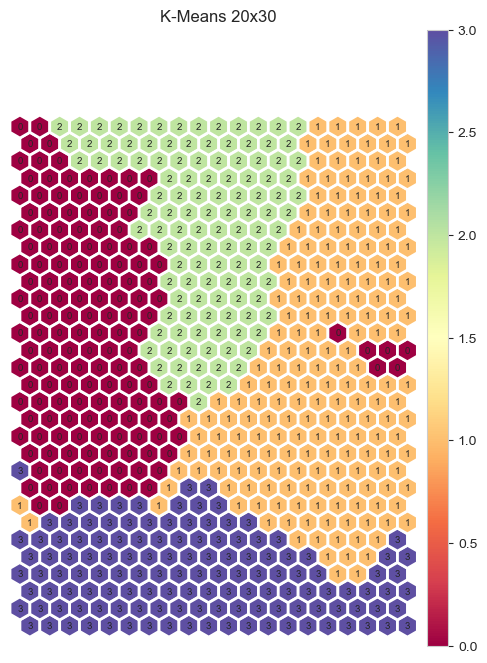

In [339]:
kmeans_matrix = kmeans_units_labels.reshape((M,N))

umatrix = sm.distance_map(scaling='mean')
fig = plt.figure(figsize=figsize)

plot_hexagons(kmeans_matrix,
              sm, fig, 
              label=f"K-Means {M}x{N}",
              cmap=cm.Spectral, 
              annot_mx=kmeans_matrix
              )

plt.show()

#### Do the cluster boundaries align with high U-Matrix distances ? 

#### Which clusters have outliers ? 

<Axes: xlabel='Kmeans_labels'>

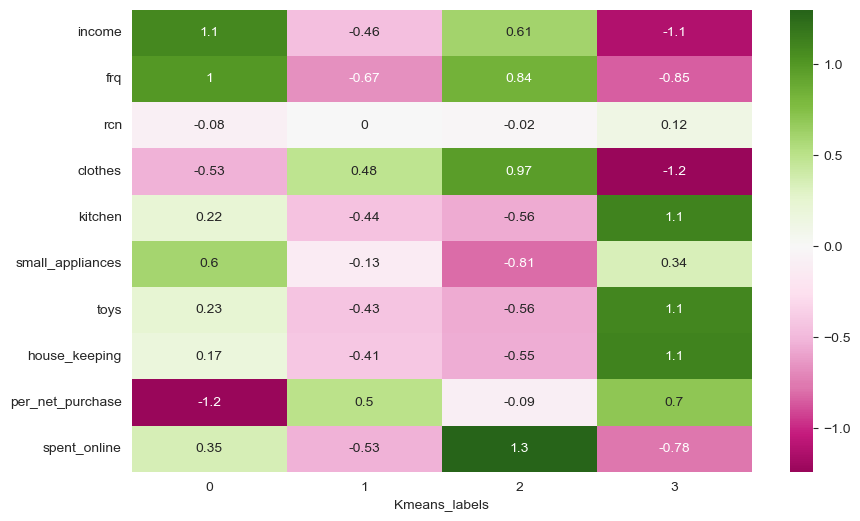

In [340]:
mat = df_final[metric_features + ['Kmeans_labels']].groupby('Kmeans_labels').mean().round(2)

sns.heatmap(mat.T, annot=True, cmap='PiYG', center=0)

#### Do the clusters average correlate with the component observed earlier ?

.

.



## Course Project Transfer

**Apply SOMs to Your Airline Customer Segmentation Project**
